# ECS 171 Project Group 13

## Are we able to identify what job you are looking for based on the scanning of your resume?

### Team Leader: Zhuoheng Li
### Team Members: Dongxian Li, Zhuoheng Li, Angelina Lim, Adham Niazi, Pramesh Sharma

Goals: The purpose of our project is to develop an accurate resume categorization model that can predict the success rate of a person who is applying to a specific job title, and determine the likelihood a resume will pass the ATS check.

Resume Dataset: https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset/data

In [19]:
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv("UpdatedResumeDataSet.csv")

# Create a New Column for the Cleaned Resume without special characters
dataset['Cleaned Resume'] = ''

display(dataset)

PermissionError: [Errno 1] Operation not permitted: 'UpdatedResumeDataSet.csv'

**Notes:** You can notice that in the dataset of the resume it contains symbols such as "â¢" or "\r\n", we need to clean the dataset so that we are able to properly analyze the data. 

In [14]:
import re

def cleanResume(text):
    # Define patterns for substitutions
    patterns = [
        r'http\S+\s*',       # remove URLs
        r'RT|cc',            # remove RT and cc
        r'#\S+',             # remove hashtags
        r'@\S+',             # remove mentions
        r'[^\w\s]',          # remove punctuations except underscore
        r'[^\x00-\x7f]'      # remove non-ASCII characters
    ]
    
    # Apply substitutions
    for pattern in patterns:
        text = re.sub(pattern, ' ', text)
    
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    
    return text.strip()  # Remove leading/trailing spaces

dataset['Cleaned Resume'] = dataset.Resume.apply(lambda x: cleanResume(x))

display(dataset)

,Category,Resume,Cleaned Resume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...
...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,Computer Skills Proficient in MS office Word B...
958,Testing,â Willingness to accept the challenges. â ...,Willingness to a ept the challenges Positive t...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",PERSONAL SKILLS Quick learner Eagerness to lea...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...


**Exploratory Data Analysis:**

**Question:** Is our model able to accurately scan your resume and predict what job you are applying for?

In [15]:
print("Displaying the categories of jobs that people are applying for: ")
print(dataset['Category'].unique())

print("\nHow many resumes are applying for each job?")

print(dataset['Category'].value_counts())

Displaying the categories of jobs that people are applying for: 
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']

How many resumes are applying for each job?
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical En

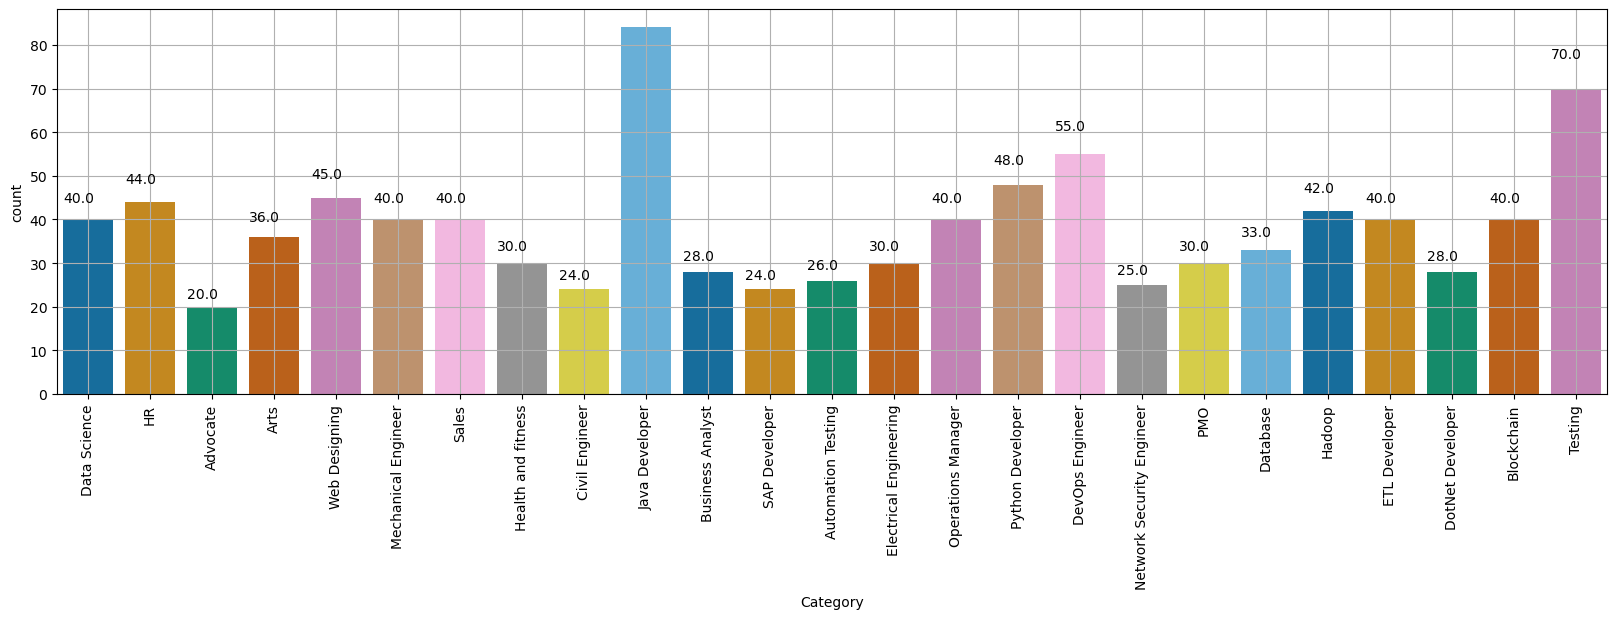

In [16]:
def plot_count_with_annotations(data, x_column):
    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=90)
    
    # Create the count plot
    ax = sns.countplot(x=x_column, data=data, palette = 'colorblind')
    
    # Annotate each bar with its height
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.1))
    
    plt.grid()
    plt.show()

plot_count_with_annotations(dataset, 'Category')

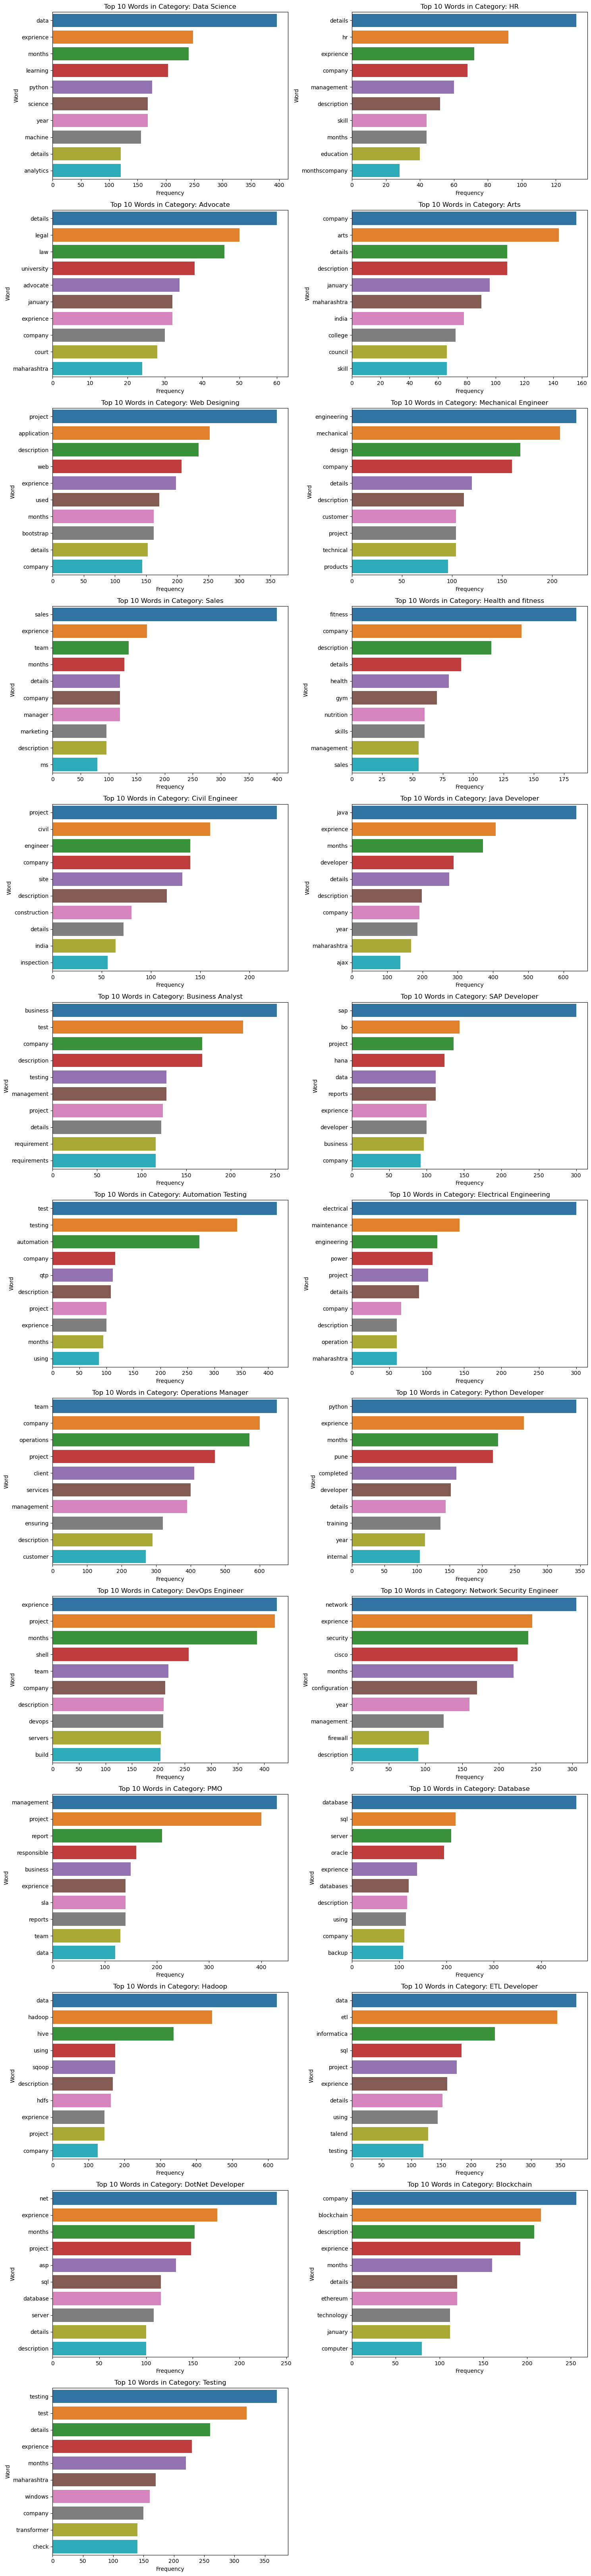

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

categories = dataset['Category'].unique()
cv = CountVectorizer(stop_words='english')
num_plots = len(categories)
num_cols = 2  # Number of columns for subplots
num_rows = - (-num_plots // num_cols)  # Calculate number of rows needed

plt.figure(figsize=(15, 5 * num_rows))

for i, category in enumerate(categories):
    plt.subplot(num_rows, num_cols, i + 1)
    subset = dataset[dataset['Category'] == category]['Cleaned Resume']
    cv_fit = cv.fit_transform(subset)
    word_list = cv.get_feature_names_out()
    count_list = cv_fit.toarray().sum(axis=0)
    word_freq_df = pd.DataFrame({'Word': word_list, 'Frequency': count_list})
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).head(10)
    
    sns.barplot(x='Frequency', y='Word', data=word_freq_df)
    plt.title(f'Top 10 Words in Category: {category}')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X = dataset['Cleaned Resume']
y = dataset['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

classifier = SVC(kernel='linear')
classifier.fit(X_train_tfidf, y_train)

predictions = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.9948186528497409
Classification Report:
                            precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
        

In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

# Assuming your DataFrame has a column named 'text' containing the text data
text_corpus = "\n".join(dataset['Cleaned Resume'].astype(str).tolist())

# Initialize GPT-2 tokenizer and model
model_name = "gpt2"  # or specify a different GPT-2 variant
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Save the text corpus to a file
corpus_file_path = "text_corpus.txt"
with open(corpus_file_path, "w", encoding="utf-8") as file:
    file.write(text_corpus)

# Create a TextDataset and DataCollator
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=corpus_file_path,
    block_size=256  # Adjust as needed
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # For language modeling tasks
)

# Initialize the GPT-2 model
model = GPT2LMHeadModel.from_pretrained(model_name)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,  # Adjust as needed
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Fine-tune the model
trainer.train()


/Users/prameshsharma25/Desktop/ECS 171/LLM-Resume/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/prameshsharma25/Desktop/ECS 171/LLM-Resume/env/lib/python3.11/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
 34%|███▎      | 500/1482 [14:43<56:21,  3.44s/it]  

{'loss': 4.0402, 'learning_rate': 3.3130904183535766e-05, 'epoch': 1.01}


 67%|██████▋   | 1000/1482 [29:30<12:33,  1.56s/it] 

{'loss': 3.0557, 'learning_rate': 1.6261808367071525e-05, 'epoch': 2.02}


100%|██████████| 1482/1482 [1:01:45<00:00,  2.50s/it]

{'train_runtime': 3705.8056, 'train_samples_per_second': 1.598, 'train_steps_per_second': 0.4, 'train_loss': 3.2370123612253288, 'epoch': 3.0}


TrainOutput(global_step=1482, training_loss=3.2370123612253288, metrics={'train_runtime': 3705.8056, 'train_samples_per_second': 1.598, 'train_steps_per_second': 0.4, 'train_loss': 3.2370123612253288, 'epoch': 3.0})

In [7]:
model.save_pretrained("./gpt2-finetuned", save_config=True, save_tokenizer=True)
tokenizer.save_pretrained("./gpt2-finetuned")

/Users/prameshsharma25/Desktop/ECS 171/LLM-Resume/env/lib/python3.11/site-packages/transformers/modeling_utils.py:2025: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(


('./gpt2-finetuned/tokenizer_config.json',
 './gpt2-finetuned/special_tokens_map.json',
 './gpt2-finetuned/vocab.json',
 './gpt2-finetuned/merges.txt',
 './gpt2-finetuned/added_tokens.json')

In [8]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained("./gpt2-finetuned")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-finetuned")

# Generate text
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
generated_text = text_generator("Your prompt here", max_length=100, num_return_sequences=1)

print(generated_text[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Your prompt here is to change company to another company and also present the change request and requirement document Also present the Change Request and Documentation such as Emails Registration Change and Change Request and Change Tracking company Eduoloop India Pvt Ltd description Responsibilities Documentation change order documentation Change request related topic documentation Create new topic topics for meeting requirements Implement obsolete or obsolete requirement Change Tracking Change Request Documentation Create new topic or topics from existing topic or related document Create new topic for meeting requirement Create change request using standard workflow Change Tracking Change
